In [1]:
# IMPORTS

#---------------------------------------
import numpy as np
from matplotlib import pyplot as plt
from astropy import constants as astro_const
import scipy

import copy # To copy multidimensional arrays
from scipy import signal # Data analysis

#---------------------------------------------
# Animation libraries
import os
import imageio

In [2]:
# INPUT READING FUNCTIONS

#---------------------------------------------
# Read the input file:
#
# N = number of particles
# N_dim = number of dimensions
# t_0 = initial time
# m_1
# ...
# m_N
# x_1, y_1, z_1
# ...
# x_n, y_n, z_n
# vx_1, vy_1, vz_1
# ...
# vx_n, vy_n, vz_n
#
#
def read_input(input_file_path):
    input_file = open(input_file_path)

    # readline() reads the first line and returns it as a string
    N = int(input_file.readline())
    N_dim = int(input_file.readline())
    t_0 = float(input_file.readline())
    masses = []
    positions = []
    velocities = []

    for i in range(N):
        masses.append(input_file.readline())
        masses[i] = masses[i].replace('\n','')
        masses[i] = float(masses[i])

    for i in range(N):
        positions.append(input_file.readline())
        positions[i] = positions[i].replace('\n','')

    for i in range(N):
        velocities.append(input_file.readline())
        velocities[i] = velocities[i].replace('\n','')

    input_file.close()

    # Convert the list of strings into a list of lists of number
    for i in range(N):
        # split() splits a string based on a separator (default is ' ') and returns a list of strings
        positions[i] = positions[i].split()
        velocities[i] = velocities[i].split()

        # Convert the elements of each splitted string into numbers
        for j in range(N_dim):
            positions[i][j] = float(positions[i][j])
            velocities[i][j] = float(velocities[i][j])

    snapshot_0 = [N, t_0, masses, positions, velocities]

    return snapshot_0
#-----------------------------------------------------------------------------
# Read the output file:
# Output file is structured as follow:
#
# N = number of particles
# N_dim = number of dimensions
# t_0 = initial time
# m_1
# ...
# m_N
# x_1, y_1, z_1
# ...
# x_n, y_n, z_n
# vx_1, vy_1, vz_1
# ...
# vx_n, vy_n, vz_n
#
def read_output(output_file_path):
    output_file = open(output_file_path)

    # List to store all the snapshots in the output file
    snapshots = []

    # Try except here detects the EOF
    # int() throws an exception when tries to convert something different than a number
    while True:
        try:
            N = int(output_file.readline())
        except:
            break

        masses = []
        positions = []
        velocities = []

        # Line after N is the number of dimensions and then the time stamp of the snapshot
        N_dim = int(output_file.readline())
        t_stamp = float(output_file.readline())

        # masses, positions and velocities
        for i in range(N):
            masses.append((output_file.readline()))
            masses[i] = masses[i].replace('\n','')  
            masses[i] = float(masses[i])

        for i in range(N):
            positions.append(output_file.readline())
            positions[i] = positions[i].replace('\n','')

        for i in range(N):
            velocities.append(output_file.readline())
            velocities[i] = velocities[i].replace('\n','')

        # Convert the list of strings into a list of lists of number (same as for read_input())
        for i in range(N):
            positions[i] = positions[i].split()
            velocities[i] = velocities[i].split()

        # Convert the elements of each splitted string into numbers
            for j in range(N_dim):
                positions[i][j] = float(positions[i][j])
                velocities[i][j] = float(velocities[i][j])
        
        snapshots.append([N, t_stamp, masses, positions, velocities])

    output_file.close()
    
    return snapshots

#--------------------------------------------------------------------------
# Returns:
#   
# The complete list of snapshots of the system (including the initial one)
#
# How to navigate the snapshots:
# 1) Choose the snapshot:
#    *** snapshots[snapshot_index, from 0 to len(snapshot)-1] ***
#
# 2) What do you want?
#    A) Number of particles:
#       *** snapshot[snapshot_index][0] ***
#       Note that snapshot[snapshot_index][0] can't be subscripted anymore
#
#    B) Time stamp: 
#       *** snapshot[snapshot_index][1] ***
#       Note that snapshot[snapshot_index][1] can't be subscripted anymore
#
#    C) Particles masses:
#       *** snapshot[snapshot_index][2] ***
#       This is a list
#
#    D) List of lists of position of all particles:
#       [ [x_1,y_1,z_1], ..., [x_n,y_n,z_n] ]
#       to pick a 3D-position vector for a particle: snapshot[snapshot_index][3][particle_index, from 0 to N-1]
#       to pick a cartesian coordinate: snapshot[snapshot_index][3][particle_index, from 0 to N-1][0,1,2] (x,y,z)
#
#    E) List of Lists of velocities of all particles:
#       [ [vx_1,vy_1,vz_1], ..., [vx_n,vy_n,vz_n] ]
#       to pick a 3D-velocity vector for a particle: snapshot[snapshot_index][4][particle_index, from 0 to N-1]
#       to pick a cartesian coordinate: snapshot[snapshot_index][4][particle_index, from 0 to N-1][0,1,2] (vx,vy,vz)
#       
#

def read_snapshots(input_file_path, output_file_path):
    snapshot_0 = read_input(input_file_path)
    snapshots = read_output(output_file_path)

    # Append the intial snapshot to the beginning of the list
    snapshots = [snapshot_0] + snapshots

    return snapshots

In [3]:
# MATHEMATICAL FUNCTIONS

#-------------------------------------------------------------------------
# Returns the difference between two vectors (vector_2 - vector_1)
# 
# If vectors are positions:
# It is a vector that points from position_1 to position_2: [x_2 - x_1, y_2 - y_1, z_2 - z_1]
# 
# If vectors are velocities:
# It is a vectors that describes the relative velocity in the frame in which particle 1 is at rest
# [vx_2 - vx_1, vy_2 - vy_1, vz_2 - vz_1]
#
# Imput parameters are strictly numpy arrays of 3 numbers: (x, y, z)
def compute_vector_diff(vector_1, vector_2):
    return vector_2 - vector_1

# Returns the vectorial product of two vectors
# Imput parameters are strictly numpy arrays of 3 numbers: (x, y, z)
def compute_vectorial_product(vector_1, vector_2):
    x = vector_1[1] * vector_2[2] - vector_1[2] * vector_2[1]
    y = vector_1[2] * vector_2[0] - vector_1[0] * vector_2[2]
    z = vector_1[0] * vector_2[1] - vector_1[1] * vector_2[0]

    return np.array([x, y, z])

# Returns the absolute value of a vector to the absval-th power
def compute_vector_abs(vector, absval=1):
    value = 0

    for i in range(len(vector)):
        value += vector[i] ** 2
    
    # Don't waste computational power if you want the square of the vector
    if absval == 2:
        pass
    else:
        value = value ** (absval / 2)

    return value

# Returns the distance between two points
# Imput parameters are arrays of 3 numbers: (x, y, z)
def compute_distance(point_1, point_2):
    distance = 0
    for i in range (3):
        distance += (point_1[i] - point_2[i]) ** 2
    
    return distance ** (1 / 2)

In [4]:
# COORDINATES FUNCTIONS

#----------------------------------------------------------------
# Returns the 3D vector (x, y, z) correspoding to the spherical_coordinates (r, theta, phi)
# Imput parameter is strictly a numpy array of 3 numbers: (r, theta, phi)
def spherical_to_cartesian(spherical_coordinates):
    r = spherical_coordinates[0]
    theta = spherical_coordinates[1]
    phi = spherical_coordinates[2]

    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)

    # Floating point precision would not give exact results around zeros of goniometric functions
    return np.array([x, y, z])

# Returns the 3D vector (r, theta, phi) correspoding to the cartesian_coordinates (x, y, z)
# Imput parameter is strictly a numpy array of 3 numbers: (x, y, z)
def cartesian_to_spherical(cartesian_coordinates):
    x = cartesian_coordinates[0]
    y = cartesian_coordinates[1]
    z = cartesian_coordinates[2]

    r = ((x ** 2) + (y ** 2) + (z ** 2)) ** (1 / 2)

    if x == 0 and y == 0 and z == 0:
        theta = None
    else:
        theta = np.arccos(z / r)

    if x == 0 and y == 0:
        phi = None
    else:
        phi = np.arccos(x / (r * np.sin(theta)))
        if y < 0:
            phi = 2 * np.pi - phi
    
    # Floating point precision would not give exact results around zeros of goniometric functions
    return np.array([r, theta, phi])

In [5]:
# SNAPSHOTS READING FUNCTIONS & SMALL CALCULATIONS

#------------------------------------------------------------------
# Returns an array of the number of particles of the snapshots
def get_N(snapshots):
    return np.array([snapshots[i][0] for i in range(len(snapshots))])

# Returns an array of the time stamps of the snapshots
def get_timestamps(snapshots):
    return np.array([snapshots[i][1] for i in range(len(snapshots))])

# Returns an array of the masses at the specified time
# If total=True returns the total mass

def get_masses(snapshots, total=False, time_index=0):
    if not total:
        masses = np.array(snapshots[time_index][2])
                           
    elif total:
        masses = np.sum(snapshots[time_index][2])
        
    return masses

# Compute the position or velocity of the center of mass for the specified snapshot
# Returns an array of 3 values: [qt_x, qt_y, qt_z]
# vec = 'pos', 'vel'

def get_center_of_mass(snapshots, time_index, vec=''):
    M_tot = get_masses(snapshots, total=True, time_index=time_index)
    qtX_CM, qtY_CM, qtZ_CM = 0, 0, 0

    if vec.lower() == 'pos':
        shift = 0
    elif vec.lower() == 'vel':
        shift = 1

    for i in range(snapshots[time_index][0]):
        qtX_CM += snapshots[time_index][2][i] * snapshots[time_index][3+shift][i][0]
        qtY_CM += snapshots[time_index][2][i] * snapshots[time_index][3+shift][i][1]
        qtZ_CM += snapshots[time_index][2][i] * snapshots[time_index][3+shift][i][2]
    
    qtX_CM /= M_tot
    qtY_CM /= M_tot
    qtZ_CM /= M_tot

    return np.array([qtX_CM, qtY_CM, qtZ_CM])

# absval = 0: returns an array of 3D vectors of the specified particle, for the specified quantity
#             in the specified reference frame
# [[Qx1_0, Qy_0, Qz_0], [Qx_1, Qy_1, Qz_1], ..., [len(snapshots)-1]]
# absval = n != 0: returns the absolute value of the vectors to the absval-th power
# vec = 'pos', 'vel'
# rf = 'snapshot', 'cm' (center of mass), 'particle' (specify which particle with the next parameter)
# if time_index is an integer, only the vector corresponding to that time is returned

def get_3D_vec(snapshots, particle_index, center_of_mass, vec='', absval=0, rf='snapshot', rf_particle_index=None, time_index=None):
    if vec.lower() == 'pos':
        shift = 0
    elif vec.lower() == 'vel':
        shift = 1
    
    # Define parameters for range() calls
    start_time = 0
    stop_time = len(snapshots)
    step = 1

    # If time_index is specified then modify the parameters in order to get just that time
    if type(time_index) == int:
        start_time = time_index
        step = stop_time

    # Compute in the snapshot reference frame
    if rf.lower() == 'snapshot':
        result = np.array([snapshots[i][3+shift][particle_index][0:3] for i in range(start_time, stop_time, step)])
    
    # Compute in the center of mass reference frame
    elif rf.lower() == 'cm':
        result = compute_vector_diff(np.array([center_of_mass[i] for i in range(start_time, stop_time, step)]),
                                               np.array([snapshots[i][3+shift][particle_index][0:3] 
                                                         for i in range(start_time, stop_time, step)]))
    
    # Compute in the reference frame of the specified particle
    elif rf.lower() == 'particle':
        result = compute_vector_diff(np.array([snapshots[i][3+shift][rf_particle_index][0:3] for i in range(len(snapshots))]),
                                               np.array([snapshots[i][3+shift][particle_index][0:3]
                                                         for i in range(start_time, stop_time, step)]))
    
    # Return the result as it is
    if absval == 0:
        pass
    
    # Compute the absval-th power of every vector into "result"
    elif absval != 0:
        for i in range(len(result)):
            result[i] = compute_vector_abs(result[i], absval)

        # Because of how numpy arrays works, we need to slice the array to take the first column
        # Actually any column would be fine because now their content is equal
        # The point is that we want just one set of values and not three
        result = result[:, :1]

        # Slicing returns an array with shape [[x_0], [x_1], ..., [x_(len(snapshot)-1)]]
        # Redefine the array to get rid of the 1-element lists
        result = np.array([result[i][0] for i in range(len(result))])

    # If time index is specifed then the time axis at this point would have dimension 1
    # Subscript "result" in order to get rid of the 1-sized axis
    if type(time_index) == int:
        result = result[0]

    return result

# Returns an array of the specified coordinate for the specified particle for the specified quantity
# in the specified reference frame
# vec = 'pos', 'vel'
# axe = 'x', 'y', 'z'
# rf = 'snapshot', 'cm' (center of mass), 'particle' (specify which particle with the next parameter)
# if time_index is an integer, only the specified coordinate corresponding to that time is returned
    
def get_coord(snapshots, particle_index, vec='', axe='', rf='snapshot', rf_particle_index=None, time_index=None):
    
    # coordinates works like this: coordinates[time_index][axe_index]
    # coordinates[0] returns the 3D vector of the particle at t_0
    
    coordinates = get_3D_vec(snapshots, particle_index, vec, rf=rf, rf_particle_index=rf_particle_index, time_index=time_index)

    # Swap the axis to obtain coordinates[axe_index][time_index]
    # coordinates[1] returns all the 'y' components of the particle vector at every time
    # Do this only if time_index has not been specified
    # If time_index has been specified then coordinates have already shape [x, y, z]
    # for the specified particle at the specified time
    
    if type(time_index) != int:
        coordinates = np.swapaxes(coordinates, 0, 1)

    if axe.lower() == 'x':
        coordinates = coordinates[0]
    elif axe.lower() == 'y':
        coordinates = coordinates[1]
    elif axe.lower() == 'z':
        coordinates = coordinates[2]

    return coordinates

In [6]:
# PHYSICS FUNCTIONS

#-------------------------------------------------------------------------
# Returns the energy of the system for the specified snapshot in the specified reference frame
# E_type = 'kin', 'pot', 'tot', 'all'. If 'all', returns an ordered tuple: (E_kin, E_pot, E_tot)
# rf = 'snapshot', 'cm' (center of mass)
# E_parts_kin and E_parts_pot are numpy arrays passed to the fucntion that can be modified
# This is exactly because they are arrays and the function will read their memory addresses
# They will be modified only if they have the right shape: E_parts_kin: (N, )
#                                                          E_parts_pot: (N, N)
# Where N is the number of particles
#
# *** ABOUT E_parts ***
#
# E_parts_kin is a collection of the kinetic energies of every particle at the specified time
# It works like this: E_parts_kin[particle_index]
#
# E_parts_pot is a collection of the potential energies of every particle
# with all other particles at the specified time
# It works like this: E_parts_pot[particle_index][particle_index]
# Self energies are set to zero: E_parts_pot[i][j] = 0 if i = j

# Note that if you want the total potential energy at a given time you can sum all the contents of 
# E_parts_pot but you have to divide by 2 at the end because it is a symmetric matrix

def get_energy(snapshots, time_index, center_of_mass, E_type='', rf='snapshot', rf_particle_index=None, E_parts_kin=None, E_parts_pot=None):
    
    N = snapshots[time_index][0]

    if E_type.lower() == 'kin':
        E = 0
        
        # A list of lists of the velocities squared of every mass at the specified time
        # [v_0_time_index, v_1_time_index, v_2_time_index, ..., v_(N-1)_time_index]
        
        v_squared = [get_3D_vec(snapshots, particle_index, center_of_mass, 'vel', 2, rf, rf_particle_index, time_index) for particle_index in range (N)]

        for i in range(N):
            value = (1 / 2) * snapshots[time_index][2][i] * v_squared[i]
            E += value
            
            # If requested save the individual kinetic energy
            if type(E_parts_kin) == np.ndarray and E_parts_kin.shape == (N, ):
                E_parts_kin[i] = value
                
    elif E_type.lower() == 'pot':
        E = 0
        
        # Same as above but it's for position vectors
        # positions[i] is the 3D vector of the i-th particle at specified time
        # Note that since we need just the relative distances between particles, it is not
        # necessary to compute the positions in a reference frame different from 'snapshot'
        # Infact relative distances are frame independent
        # This solution is preferable because more computationally efficient
        
        positions = [get_3D_vec(snapshots, particle_index, center_of_mass, 'pos', rf='snapshot', time_index=time_index) for particle_index in range(N)]

        # Cycle over all possible combination of particles
        # part_0: part_1, part_2, part_3, ..., part_(N-1)
        # part_1: part_2, part_3, part_4, ..., part_(N-1)
        # part_2: part_3, part_4, part_5, ..., part_(N-1)
        # ...
        # part_i: part_(i+1), part_(i+2), ..., part_(N-1)
        
        for i in range(N):
            for j in range(i+1, N):
                distance = compute_distance(positions[i], positions[j])
                value = -1 * snapshots[time_index][2][i] * snapshots[time_index][2][j] / distance
                E += value
                
                # If requested save the individual potential energy interaction
                # Build up a symmetric matrix
                if type(E_parts_pot) == np.ndarray and E_parts_pot.shape == (N, N):
                    E_parts_pot[i][j] = value
                    E_parts_pot[j][i] = value
                    
    elif E_type.lower() == 'tot':
        E_kin = get_energy(snapshots, time_index, 'kin', rf, rf_particle_index, E_parts_kin, E_parts_pot)
        E_pot = get_energy(snapshots, time_index, 'pot', rf, rf_particle_index, E_parts_kin, E_parts_pot)
        E = E_kin + E_pot

    elif E_type.lower() == 'all':
        E_kin = get_energy(snapshots, time_index, 'kin', rf, rf_particle_index, E_parts_kin, E_parts_pot)
        E_pot = get_energy(snapshots, time_index, 'pot', rf, rf_particle_index, E_parts_kin, E_parts_pot)
        E = E_kin + E_pot

        E = E_kin, E_pot, E

    return E

In [7]:
# PROBLEM SPECIFIC FUNCTIONS

#-------------------------------------------------
def get_sphere_volume(radius):
    return (4 * np.pi / 3) * radius ** 3

def get_collapse_time(density): # G = 1
    T_w = (3 * np.pi / density) ** (1 / 2)
    return T_w / (4 * 2 ** (1 / 2))

In [8]:
# GLOBAL VARIABLES

#---------------------------------------------
# Relevant constants in CGS
G = astro_const.G.cgs
M_sun = astro_const.M_sun.cgs
R_sun = astro_const.R_sun.cgs

# Internal units conversion factors: G = 1, M = 1 M_sun, r = 1 kpc
v_I_to_v_cgs = (G * M_sun / 10*R_sun) ** (1 / 2)
t_I_to_t_cgs = 10*R_sun / v_I_to_v_cgs

# Strings for units
mass_unit_str = "$M_\odot$"
distance_unit_str = "$kpc$"

# Printing conversion factors
print(v_I_to_v_cgs)
print(t_I_to_t_cgs)

9.608748332014945e+17 cm2 / s
7.24027704713661e-07 s / cm


202


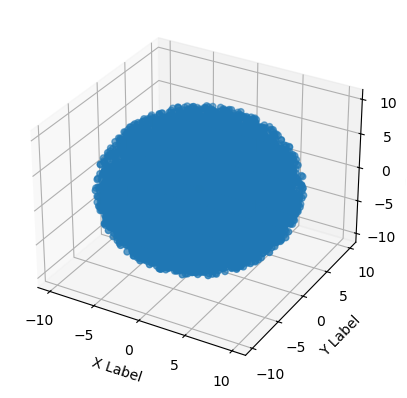

In [9]:
# FILE READING

#----------------------------------------------------------------
input_file_path = "Test_2/treecode_filein.txt"
output_file_path = "Test_2/treecode_fileout.txt"

snapshots = read_snapshots(input_file_path, output_file_path)
print(len(snapshots))

N = snapshots[0][0] # Number of particles
#print(snapshots[1])#[0][2][11000:11100])

# "cm_pos" works like this: cm_pos[time_index][coordinate_index]
cm_pos = np.array([get_center_of_mass(snapshots, time_index, 'pos') for time_index in range(len(snapshots))])

# "pos" works like this: pos[particle_index][time_index][coordinate_index]
pos = np.array([get_3D_vec(snapshots, particle_index, cm_pos, 'pos', rf='snapshot') for particle_index in range(N)])

time_stamp = get_timestamps(snapshots)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(pos[:,0,0], pos[:,0,1], pos[:,0,2])
ax.scatter(cm_pos[:,0], cm_pos[:,1], cm_pos[:,2])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

#ax.set_xlim(-1, 1)
#ax.set_ylim(-1, 1)
#ax.set_zlim(-1, 1)
plt.show()

In [17]:
# READING ENERGIES

# Ttotal time and timesteps required!
Energies = []
jump = 0
t_tot = 40 
time_steps = 0.2

# I don't remember why the +1 
Steps = t_tot / time_steps + 1
fp = open('Test_2/logfile')

while jump < Steps*8:
    
    Energies.append(np.genfromtxt('Test_2/logfile', skip_header = 10 + jump,  usecols = (0,1,2,3,), max_rows = 1, delimiter = ' '))
    jump += 8
    
fp.close()

# Energies:
# Energies[0] = Time for each step: 0, dt, 2dt ... t_tot
# Energies[1] = Abs value of total energy
# Energies[2] = Total kinetic energy
# Energies[3] = - Total_potential energy

print(np.shape(Energies))

Energies = np.copy(Energies)

# Ttotal time and timesteps required!
Energies_1 = []
jump = 0

fp = open('Test_1/logfile')

while jump < Steps*8:
    
    Energies_1.append(np.genfromtxt('Test_1/logfile', skip_header = 10 + jump,  usecols = (0,1,2,3,), max_rows = 1, delimiter = ' '))
    jump += 8
    
fp.close()

# Energies:
# Energies[0] = Time for each step: 0, dt, 2dt ... t_tot
# Energies[1] = Abs value of total energy
# Energies[2] = Total kinetic energy
# Energies[3] = - Total_potential energy

print(np.shape(Energies_1))

Energies_1 = np.copy(Energies_1)
# Ttotal time and timesteps required!
Energies_3 = []
jump = 0

fp = open('Test_3/logfile')

while jump < Steps*8:
    
    Energies_3.append(np.genfromtxt('Test_3/logfile', skip_header = 10 + jump,  usecols = (0,1,2,3,), max_rows = 1, delimiter = ' '))
    jump += 8
    
fp.close()

# Energies:
# Energies[0] = Time for each step: 0, dt, 2dt ... t_tot
# Energies[1] = Abs value of total energy
# Energies[2] = Total kinetic energy
# Energies[3] = - Total_potential energy

print(np.shape(Energies_3))

Energies_3 = np.copy(Energies_3)



(201, 4)
(201, 4)
(201, 4)


In [18]:
# Initialise a list to store the generated figures 
figures = []

# Initialise a list to store their names
figures_names = []

Test_0.1
'kin' Collpase time = 35.400063
'pot' Collpase time = 35.400063
Test_0.01
'kin' Collpase time = 35.200062
'pot' Collpase time = 35.200062
Test_0.001
'kin' Collpase time = 36.400066
'pot' Collpase time = 36.400066


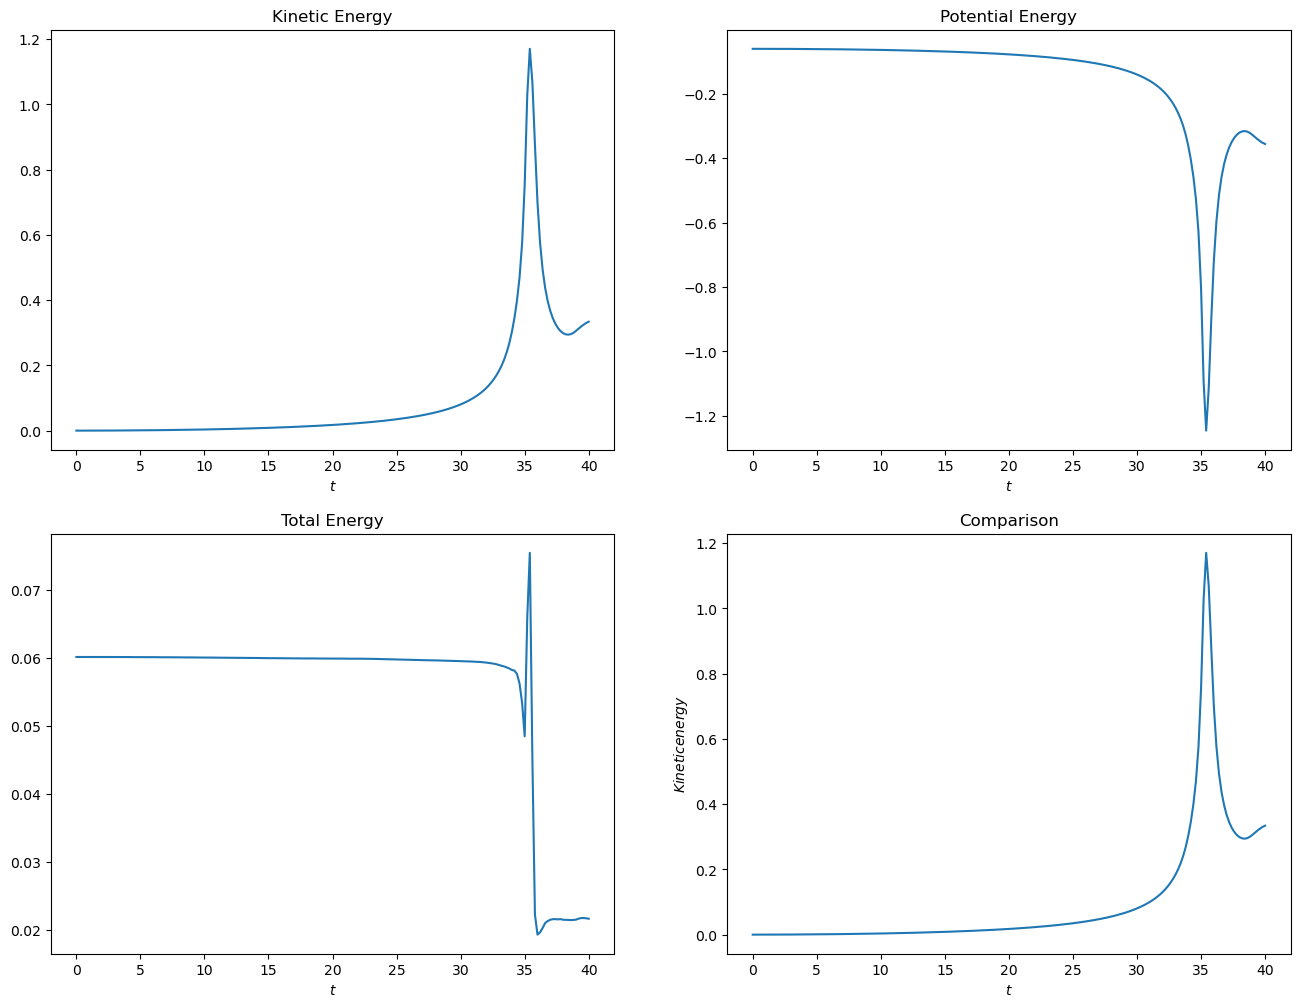

In [19]:
# ENERGY PLOTS

#----------------------------------------------------------------------
# These are ordered to match the Energy_keys
title_labels = ["Kinetic Energy", "Potential Energy", "Total Energy"]

n_rows = 2
n_col = 2

fig, ax = plt.subplots(n_rows, n_col, figsize=(16,12))

index = 0 # Index to count cycles and break
print('Test_0.1')
collapse_index_1 = np.argmax(Energies_1[:,2])
print("'kin' Collpase time = " + str(time_stamp[collapse_index_1]))

collapse_index_1 = np.argmin(- Energies_1[:,3])
print("'pot' Collpase time = " + str(time_stamp[collapse_index_1]))

print('Test_0.01')
collapse_index = np.argmax(Energies[:,2])
print("'kin' Collpase time = " + str(time_stamp[collapse_index]))

collapse_index = np.argmin(- Energies[:,3])
print("'pot' Collpase time = " + str(time_stamp[collapse_index]))

print('Test_0.001')
collapse_index_3 = np.argmax(Energies_3[:,2])
print("'kin' Collpase time = " + str(time_stamp[collapse_index_3]))

collapse_index_3 = np.argmin(- Energies_3[:,3])
print("'pot' Collpase time = " + str(time_stamp[collapse_index_3]))


for i in range(n_rows):
    for j in range(n_col):
        ax[i][j].set_title(title_labels[index])
        ax[i][j].set_xlabel("$t$")

        index +=1
        if index == 3:
            break

# Because of the reading, I have two times the initial conditions: 
# time_stamp[0] = time_Stamp[1] = 0 (one from the input file, the 
# other from the output)

ax[0][0].plot(Energies[:,0], Energies[:,2])
#ax[0][0].vlines(time_stamp[collapse_index ], 0, 1.2,color = 'r', ls = '--')
ax[0][1].plot(Energies[:,0], -Energies[:,3])
#ax[0][1].vlines(time_stamp[collapse_index], 0, -1.2, color = 'r', ls = '--')
ax[1][0].plot(Energies[:,0], Energies[:,1])

ax[1][1].set_title("Comparison")
ax[1][1].plot(time_stamp[1:], Energies[:,2])
ax[1][1].set_xlabel("$t$")
ax[1][1].set_ylabel("$Kinetic energy$")


figures.append(fig)
figures_names.append("energy")


plt.show()

Test_0.1
Expected Collapse time = 35.12407365520362
Simulation Collpase time = 35.400063
Relative Error = 0.7857555120332645 %
Test_0.01
Expected Collapse time = 35.12407365520362
Simulation Collpase time = 35.200062
Relative Error = 0.21634263024934805 %
Test_0.001
Expected Collapse time = 35.12407365520362
Simulation Collpase time = 36.400066
Relative Error = 3.6328142268524934 %


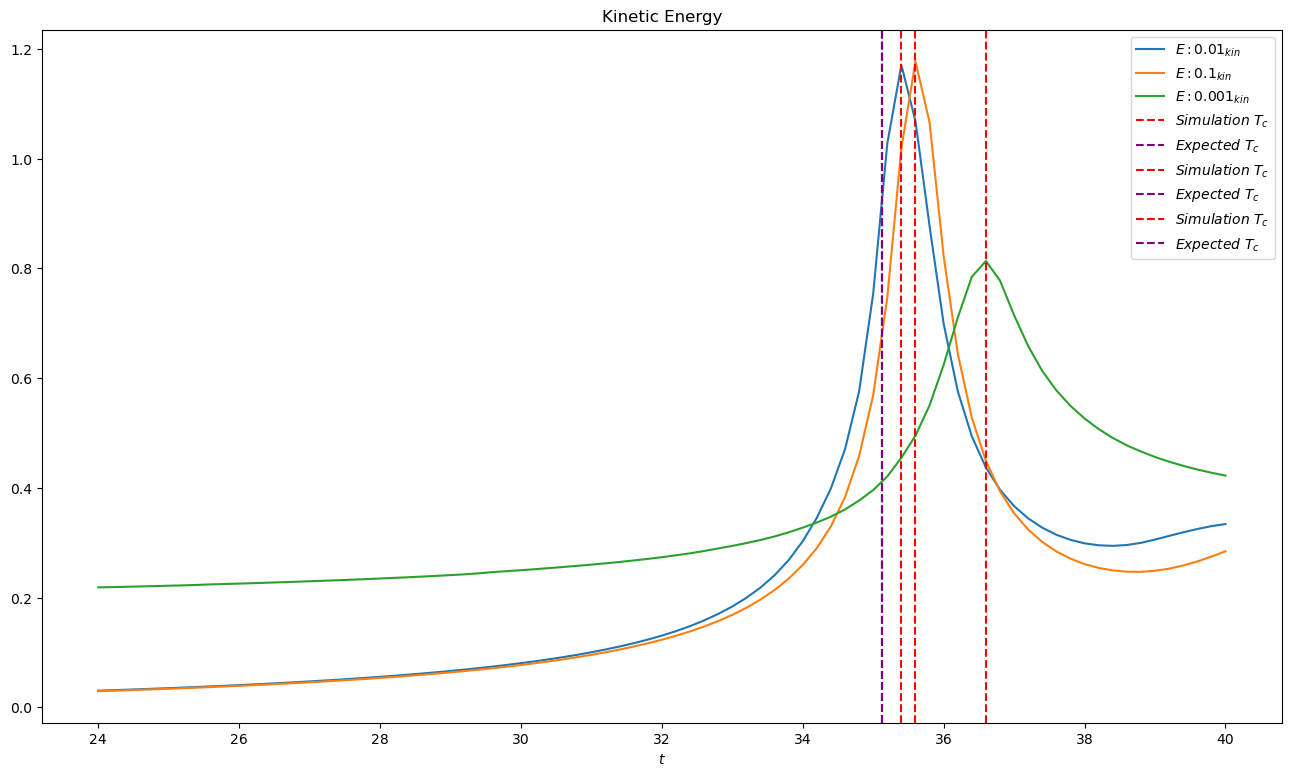

In [23]:
expected_collapse_time = get_collapse_time(get_masses(snapshots, total=True) / get_sphere_volume(10))

print('Test_0.1')
print("Expected Collapse time = " + str(expected_collapse_time))
print("Simulation Collpase time = " + str(time_stamp[collapse_index_1]))
print("Relative Error = " + str(100 * (time_stamp[collapse_index_1] - expected_collapse_time) / expected_collapse_time) + " %")

print('Test_0.01')
print("Expected Collapse time = " + str(expected_collapse_time))
print("Simulation Collpase time = " + str(time_stamp[collapse_index]))
print("Relative Error = " + str(100 * (time_stamp[collapse_index] - expected_collapse_time) / expected_collapse_time) + " %")

print('Test_0.001')
print("Expected Collapse time = " + str(expected_collapse_time))
print("Simulation Collpase time = " + str(time_stamp[collapse_index_3]))
print("Relative Error = " + str(100 * (time_stamp[collapse_index_3] - expected_collapse_time) / expected_collapse_time) + " %")

fig, ax = plt.subplots(figsize=(16,9))

ax.set_title(title_labels[0])
ax.plot(time_stamp[121:], Energies[120:,2], label='$E:0.01_{kin}$')
ax.plot(time_stamp[121:], Energies_1[120:,2], label='$E:0.1_{kin}$')
ax.plot(time_stamp[121:], Energies_3[120:,2], label='$E:0.001_{kin}$')
ax.set_xlabel("$t$")

ax.axvline(time_stamp[collapse_index+1], color='red', ls='--', label='$Simulation\ T_c$')
ax.axvline(expected_collapse_time, color='purple', ls='--', label='$Expected\ T_c$')
ax.axvline(time_stamp[collapse_index_1+1], color='red', ls='--', label='$Simulation\ T_c$')
ax.axvline(expected_collapse_time, color='purple', ls='--', label='$Expected\ T_c$')
ax.axvline(time_stamp[collapse_index_3+1], color='red', ls='--', label='$Simulation\ T_c$')
ax.axvline(expected_collapse_time, color='purple', ls='--', label='$Expected\ T_c$')

ax.legend()

figures.append(fig)
figures_names.append("kinetic")

plt.show()

In [16]:
particles_distance_cm =  np.array([get_3D_vec(snapshots, particle_index, cm_pos, 'pos', absval=1, rf='cm') for particle_index in range(N)])

# part_dist_cm works like this: part_dist_cm[particle_index][time_index]
print(np.shape(particles_distance_cm))
part_dist_cm = np.swapaxes(particles_distance_cm, 0, 1)
print(np.shape(part_dist_cm))

(10000, 202)
(202, 10000)


1.0000000000000004
10.027230491111766


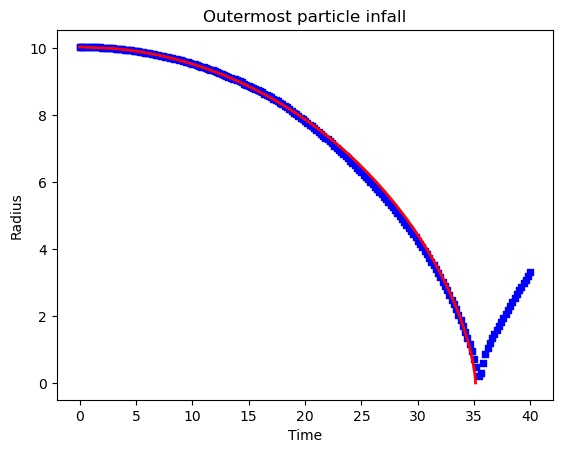

In [17]:
# HOMOLOGOUS COLLAPSE CHECK:
M_tot = np.sum(snapshots[0][2])
print(M_tot)

# Study the mass at each radius interval to understand wheter the collapse is homologous or not
r_max = np.max(particles_distance_cm[:,0])
r_max_index = np.argmax(particles_distance_cm[:,0])
print(r_max)

r_max_o = r_max

radius_intervals = np.linspace(0, r_max, len(time_stamp))
reverse_radius_intervals = radius_intervals[::-1]
#print(radius_intervals)
#print(reverse_radius_intervals)
#print(np.shape(part_dist_cm))

t_of_radius = []
rho = M_tot / (4/3 * np.pi * 10.**3)
# Predicted trajectory

func = lambda r: -(3 / (8*np.pi * rho))**0.5 * ((r/r_max)**0.5 / (1 - r/r_max)**0.5) * 1/r_max

for r in reverse_radius_intervals:

    if r == r_max:
        t_of_radius.append(0)
        
    else: t_of_radius.append(scipy.integrate.quad(func, r_max, r)[0])

t_of_radius = np.copy(t_of_radius)
#print(t_of_radius)

plt.scatter(time_stamp[:], particles_distance_cm[r_max_index, :], label = 'Simulation', marker = 's', s = 15, c = 'blue')
plt.plot(t_of_radius, reverse_radius_intervals, label = 'Theorical prediction', lw = 2, c = 'red')
plt.title('Outermost particle infall')
plt.ylabel('Radius')
plt.xlabel('Time')
plt.show()

#plt.scatter(particles_distance_cm[r_max_index, :],time_stamp[:] , label = 'Simulation', marker = 's', size = '3', c = 'bue')
#plt.plot(reverse_radius_intervals, t_of_radius, label = 'Theorical prediction', lw = 3, c = 'darkorange')
#plt.ylabel('Radius')
#plt.xlabel('Time')
#plt.show()

Good collapse particles =  22
Bad collapse particles =  21


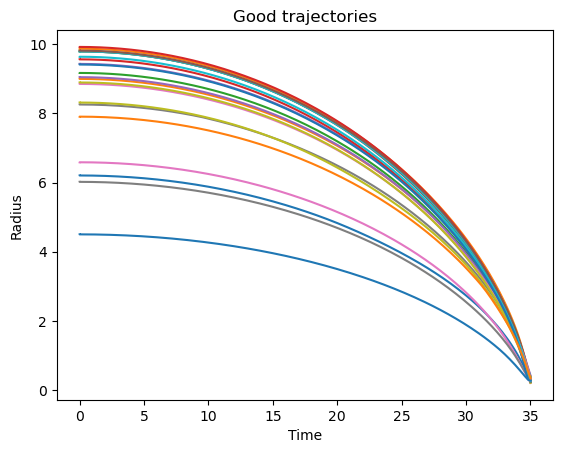

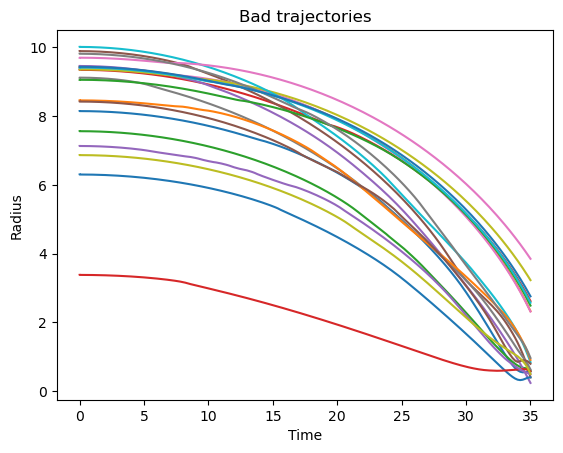

In [18]:
differences = []
good_collapse_particles = 0
bad_collapse_particles = 0
plot_vector = []

for i in range(1,2000):

    r_max = particles_distance_cm[i, 0]
    
    radius_intervals = np.linspace(0, r_max, len(time_stamp))
    reverse_radius_intervals = radius_intervals[::-1]
    t_of_radius = []

    for r in reverse_radius_intervals:

       # If you do the change of variable of the last part
       # probabily you don't need this! 
        
       if r == r_max:
           t_of_radius.append(0)
        
       else: t_of_radius.append(scipy.integrate.quad(func, r_max, r)[0])

    f = scipy.interpolate.interp1d(t_of_radius, reverse_radius_intervals)
    
    time_stamp_plot = []

    # To avoid to give time_stamps out of the interpolation
    # range... It's possible that with the cahnge of variable
    # It will not be necessary
    
    for j in range(len(time_stamp)):
        if time_stamp[j] <= t_of_radius[-1]: time_stamp_plot.append(time_stamp[j])

    last_index = np.argmax(time_stamp_plot)
    
    tot_diff = np.sum(np.abs(np.diff(f(time_stamp_plot[1:]) - particles_distance_cm[i,:last_index])))
    differences.append(tot_diff)

    if (differences[i-1] <= 0.3):

        good_collapse_particles += 1
        plt.plot(time_stamp[:collapse_index], particles_distance_cm[i, :collapse_index], label = 'Simulation' + str(i))
        #plt.plot(t_of_radius, reverse_radius_intervals, label = 'Theorical prediction', lw = 1, c = 'black')

    if (differences[i-1] >= 2.0):

        bad_collapse_particles += 1
        plot_vector.append((time_stamp[:collapse_index], particles_distance_cm[i, :collapse_index]))
        #plt.plot(t_of_radius, reverse_radius_intervals, label = 'Theorical prediction', lw = 3, c = 'black')

print('Good collapse particles = ', good_collapse_particles)
print('Bad collapse particles = ', bad_collapse_particles)

#plt.legend()
plt.title('Good trajectories')
plt.xlabel('Time')
plt.ylabel('Radius')
plt.show()

for i in range(len(plot_vector)):

    plt.plot(plot_vector[i][0], plot_vector[i][1])
    
plt.title('Bad trajectories')
plt.xlabel('Time')
plt.ylabel('Radius')
plt.show()


In [19]:
print(particles_distance_cm[:,0],'\n')
particles_distance_cm = np.sort(particles_distance_cm, axis=0)
print(particles_distance_cm[:,0],'\n')
print(particles_distance_cm[:,2])

[9.77177944 8.59314415 7.57126659 ... 8.43501631 8.75802596 4.80323016] 

[ 0.46570523  0.49733424  0.63456042 ... 10.02354919 10.02377867
 10.02723049] 

[ 0.46568587  0.49732166  0.63455499 ... 10.02335507 10.02357565
 10.02703387]


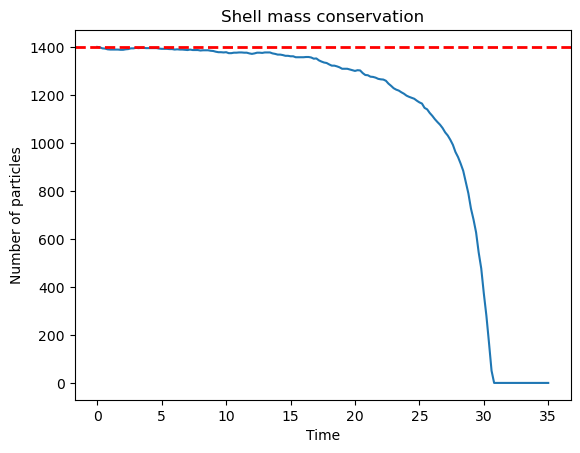

In [21]:
# MASS CHECK FOR EACH SHELL

# Choose the number of the cell
r_shell_max = particles_distance_cm[1500,0]
r_shell_min = particles_distance_cm[100,0]

r_int_max = np.linspace(0, r_shell_max, len(time_stamp))
r_int_min = np.linspace(0, r_shell_min, len(time_stamp))

rev_r_int_max = r_int_max[::-1]
rev_r_int_min = r_int_min[::-1]

t_of_radius_max = []
t_of_radius_min = []

rho = M_tot / (4/3 * np.pi * 10.**3)

func = lambda x: -(3 / (8*np.pi * rho))**0.5 * ((x**0.5) / (1 - x)**0.5) 

for r in rev_r_int_max:

    if r == r_shell_max:
        t_of_radius_max.append(0)
        
    else: t_of_radius_max.append(scipy.integrate.quad(func, 1, r/r_shell_max)[0])
        
f_max = scipy.interpolate.interp1d(t_of_radius_max, rev_r_int_max)

for r in rev_r_int_min:

    if r == r_shell_min:
        t_of_radius_min.append(0)
        
    else: t_of_radius_min.append(scipy.integrate.quad(func, 1, r/r_shell_max)[0])
        
f_min = scipy.interpolate.interp1d(t_of_radius_min, rev_r_int_min)

# Try to find if the mass on a shell is conserved during the time 
# It would mean an homologous collapse!

inside_shell = np.zeros(len(time_stamp[1:collapse_index]))

t = 1
for i in time_stamp[1:collapse_index]:
    
    for j in range(N):
        if particles_distance_cm[j,t] <= f_max(i) and particles_distance_cm[j,t] > f_min(i):
            inside_shell[t-1] += 1
    t += 1  

shell_mass = inside_shell * 1/N

Mass_diff = []

for i in range(len(time_stamp[1:collapse_index])):
    Mass_diff.append(shell_mass[i])
    
plt.plot(time_stamp[1:collapse_index], inside_shell, label = 'Evolution')
plt.axhline(inside_shell[0], lw = 2, ls ='--', c = 'r', label = 'Initial mass')
plt.title('Shell mass conservation')
plt.ylabel('Number of particles')
plt.xlabel('Time')
plt.show()
                
#fig, ax = plt.subplots(1,2, figsize=(14,8))
#ax[0].scatter([:collapse_index], )
#ax[1].scatter(radius_stamp[:collapse_index], particle_counter[:collapse_index, 0])
#ax[0].set_xlabel('Radius')
#ax[0].set_ylabel('Number of particles')
#plt.show()

#plt.scatter(time_stamp[:collapse_index], particle_counter[0, :collapse_index])
#plt.scatter(time_stamp[:collapse_index], particle_counter[46, :collapse_index])
#plt.scatter(time_stamp[:collapse_index], particle_counter[42, :collapse_index])
#plt.scatter(time_stamp[:collapse_index], particle_counter[25, :collapse_index])
#plt.show()


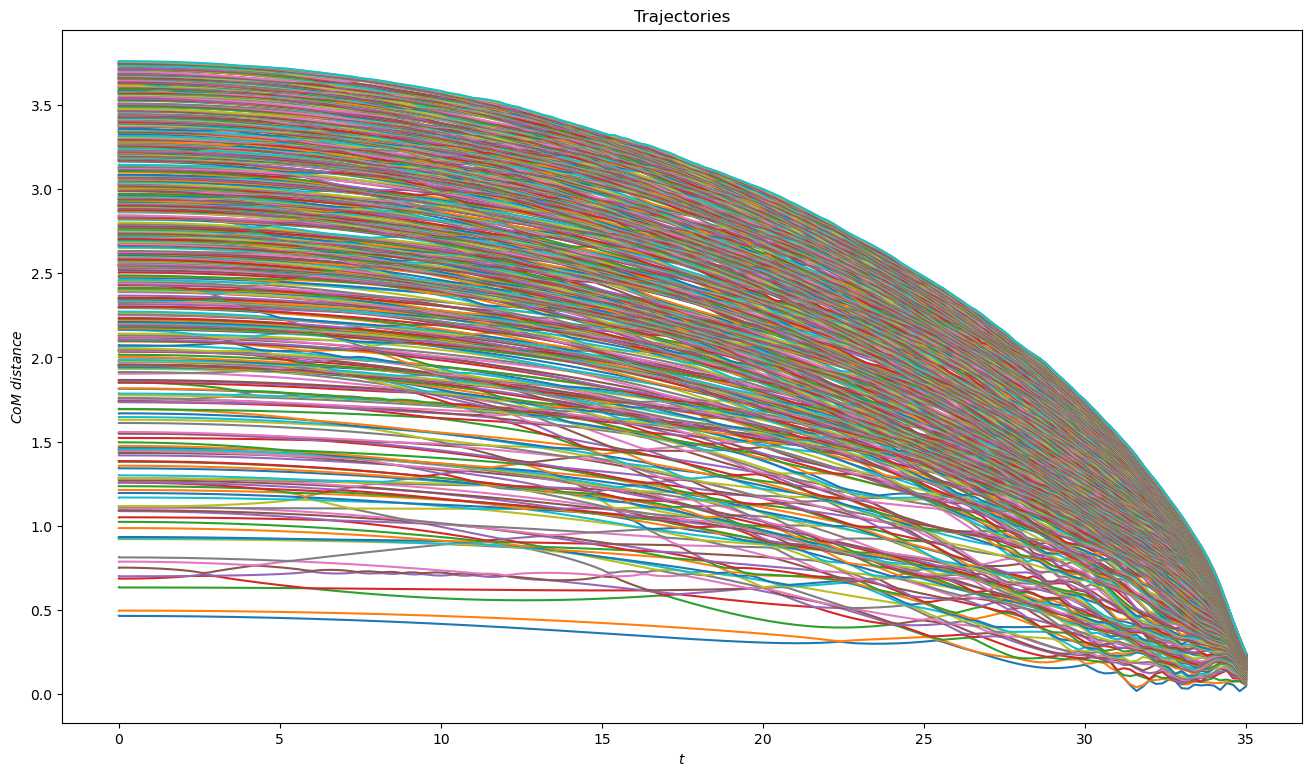

In [22]:
fig, ax = plt.subplots(figsize=(16,9))

ax.set_title("Trajectories")
ax.set_xlabel("$t$")
ax.set_ylabel("$CoM\ distance$")

for particle_index in range(500):
    ax.plot(time_stamp[:collapse_index], particles_distance_cm[particle_index, :collapse_index])

figures.append(fig)
figures_names.append("trajectories")

plt.show()

In [35]:
# IMAGE SAVER

#------------------------------------------------------------

# Toggle on/off the image saver
save_images = False

if save_images:
    # FOLDERS MANAGING

    #-------------------------------------------------------------------------
    # File paths variables
    images_dir_path = "images"

    # Create folders to store the images
    if not os.path.isdir(images_dir_path):
        os.makedirs(images_dir_path)
    
    # Empty the 'images' folder
    for file_name in os.listdir(images_dir_path):
        file_path = os.path.join(images_dir_path, file_name)
        os.remove(file_path)

    #---------------------------------------------------------------------
    # SAVING IMAGES
    for figure_index in range(len(figures)):
        figures[figure_index].savefig(os.path.join(images_dir_path, figures_names[figure_index]))